In [ ]:
import os
import sys
sys.path.append('../scripts')

import pandas as pd
import numpy as np

from PIL import Image

import torch
import torch.autograd as autograd
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms, utils
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import wandb

# Параметры модели и обучения

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
from dataset import ArchNegatives, ArchPositives
from train_wgan import compute_gradient_penalty, train_wgangp
from model_conv import Generator, Discriminator

In [ ]:
params = {
    'batch_size': 512,
    'channels': 1,
    'img_size': 64,
    'latent_dim': 100,
    'lr': 0.0002,
    'b1': 0.5,
    'b2': 0.999,
    'n_epochs': 200,
    'n_critic': 5,
    'sample_interval': 400,
}

In [ ]:
model_name = 'conv_grayscale'
results_dir = 'results_conv_grayscale'

# Датасет

In [ ]:
transform_crop_64 = transforms.Compose([
    transforms.CenterCrop((params['img_size'], params['img_size'])),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
train_dataset = ArchNegatives(transform=transform_crop_64)
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)

anomalies_dataset = ArchPositives(transform=transform_crop_64)
anomalies_loader = DataLoader(anomalies_dataset, batch_size=params['batch_size'], shuffle=False)

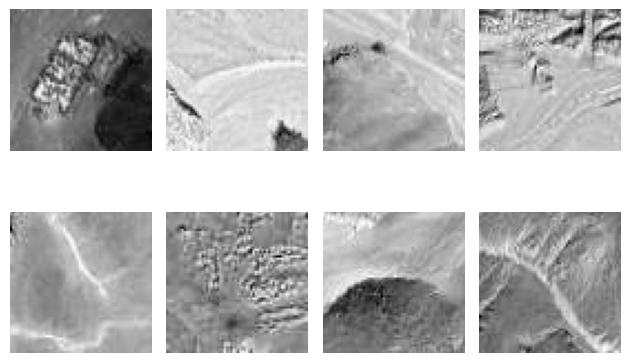

In [21]:
fig, axs = plt.subplots(nrows=2, ncols=4)

for i in range(4):
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    
    axs[0, i].imshow(anomalies_dataset[i][0].permute(1, 2, 0), cmap='gray')
    axs[1, i].imshow(train_dataset[i][0].permute(1, 2, 0), cmap='gray')
    
fig.tight_layout()
fig.show()

In [ ]:
print(f'train: {len(train_dataset)} images, {len(train_loader)} batches')
print(f'anomalies: {len(anomalies_dataset)} images, {len(anomalies_loader)} batches')

# Обучение GAN

In [ ]:
import wandb

wandb.login(key='514eb1383ebf19dfe33c9834438026c917300873')
wandb.init( project='arch_fanogan', name=f'fanogan_v2_conv_grayscale')

In [ ]:
generator = Generator(params)
discriminator = Discriminator(params)

In [ ]:
with tqdm(
    total=params['n_epochs']*len(train_loader), 
    desc=f"[Epoch ?] [Batch ?] [D loss: ?] [G loss: ?]"
) as pbar:
    train_wgangp(results_dir, pbar, params, generator, discriminator, train_loader, device)

In [ ]:
# torch.save(generator.state_dict(), f"{results_dir}/generator")
# torch.save(discriminator.state_dict(), f"{results_dir}/discriminator")